In [1]:
# import required libraries 
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam,SGD, Adagrad, Adadelta, RMSprop

from sklearn.preprocessing import LabelEncoder

In [2]:
!wget https://www.dropbox.com/s/ka1t4gpot6u7pg0/dataset.tar?dl=0

--2020-11-26 12:27:03--  https://www.dropbox.com/s/ka1t4gpot6u7pg0/dataset.tar?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.1, 2620:100:6031:1::a27d:5101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ka1t4gpot6u7pg0/dataset.tar [following]
--2020-11-26 12:27:03--  https://www.dropbox.com/s/raw/ka1t4gpot6u7pg0/dataset.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc22788cd7fa45bc34586f991a9e.dl.dropboxusercontent.com/cd/0/inline/BD4WNrk6f1GADJgo51uqm4O3KX52Qu_QcCmD7p_j-BHTmom3flFSIj3NFxTGoagsQFdOWe8HqcFwaTp83UjjSyk68xIJvBv2zLK9JrHJGWwgAa8SVQIEhBGNgPAL7Mbtg-c/file# [following]
--2020-11-26 12:27:03--  https://uc22788cd7fa45bc34586f991a9e.dl.dropboxusercontent.com/cd/0/inline/BD4WNrk6f1GADJgo51uqm4O3KX52Qu_QcCmD7p_j-BHTmom3flFSIj3NFxTGoagsQFdOWe8HqcFwaTp83UjjSyk68xIJvBv2zLK9JrHJGWwgA

In [3]:
import shutil
shutil.unpack_archive("/content/dataset.tar", "/content/dataset")

In [4]:
import os
print(os.getcwd())

/content


In [5]:
os.chdir("/content/dataset/dataset/")

In [9]:
print(os.getcwd())
print(os.listdir())

/content/dataset/dataset
['test.csv', 'train', 'train.csv', 'test']


In [10]:
working_dir = os.getcwd()
print(working_dir)
# dataframe for train.csv
train_df = pd.read_csv(working_dir+'/train.csv')
# dataframe for test.csv
test_df = pd.read_csv(working_dir+'/test.csv')

/content/dataset/dataset


In [15]:
print(train_df.head())
print(test_df.head())
print(train_df['target'].value_counts())

     Image         target
0   96.jpg       manipuri
1  163.jpg  bharatanatyam
2  450.jpg         odissi
3  219.jpg      kathakali
4  455.jpg         odissi
     Image
0  508.jpg
1  246.jpg
2  473.jpg
3  485.jpg
4  128.jpg
mohiniyattam     50
odissi           49
bharatanatyam    47
kathakali        47
kuchipudi        46
sattriya         45
kathak           44
manipuri         36
Name: target, dtype: int64


In [14]:
print(len(os.listdir(working_dir+'/train')))
print(len(os.listdir(working_dir+'/test')))

364
156


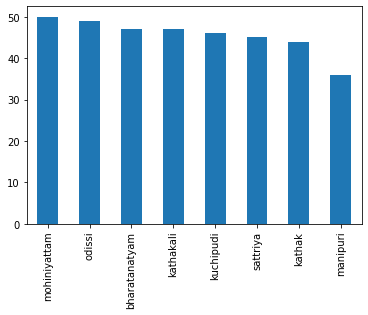

In [17]:
#Histogram chart for target
train_df['target'].value_counts().plot(kind='bar')

In [24]:
train_dir = '/content/dataset/dataset/train/'
test_dir = '/content/dataset/dataset/test/'

train_fnames = os.listdir(train_dir)
test_fnames = os.listdir(test_dir)

print(train_fnames[:9])
print(test_fnames[:9])

['259.jpg', '308.jpg', '305.jpg', '311.jpg', '164.jpg', '5.jpg', '231.jpg', '136.jpg', '351.jpg']
['108.jpg', '170.jpg', '465.jpg', '198.jpg', '394.jpg', '202.jpg', '467.jpg', '291.jpg', '421.jpg']


In [25]:
img_width = 224
img_height = 224

In [26]:
def train_data_preparation(list_of_images, train, train_dir):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    x = [] # images as arrays
    y = [] # labels
    for image in list_of_images:
        #x.append((cv2.resize(cv2.imread(train_dir+image), (img_width,img_height), interpolation=cv2.INTER_CUBIC)).astype('float32'))
        x.append(cv2.resize(cv2.imread(train_dir+image), (img_width,img_height), interpolation=cv2.INTER_CUBIC))
        if image in list(train['Image']):
            y.append(train.loc[train['Image'] == image, 'target'].values[0])
    
            
    return x, y

In [27]:
def test_data_prepare(list_of_images, test_dir):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    x = [] # images as arrays
    
    for image in list_of_images:
        x.append(cv2.resize(cv2.imread(test_dir+image), (img_width,img_height), interpolation=cv2.INTER_CUBIC)) 
            
    return x

In [28]:
training_data, training_labels = train_data_preparation(train_fnames, train_df, train_dir)

In [29]:
training_labels[:10]

['mohiniyattam',
 'mohiniyattam',
 'mohiniyattam',
 'mohiniyattam',
 'bharatanatyam',
 'kathak',
 'kathakali',
 'bharatanatyam',
 'sattriya',
 'kuchipudi']

In [30]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(12,12))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(label_batch[n].title())
        plt.axis('off')

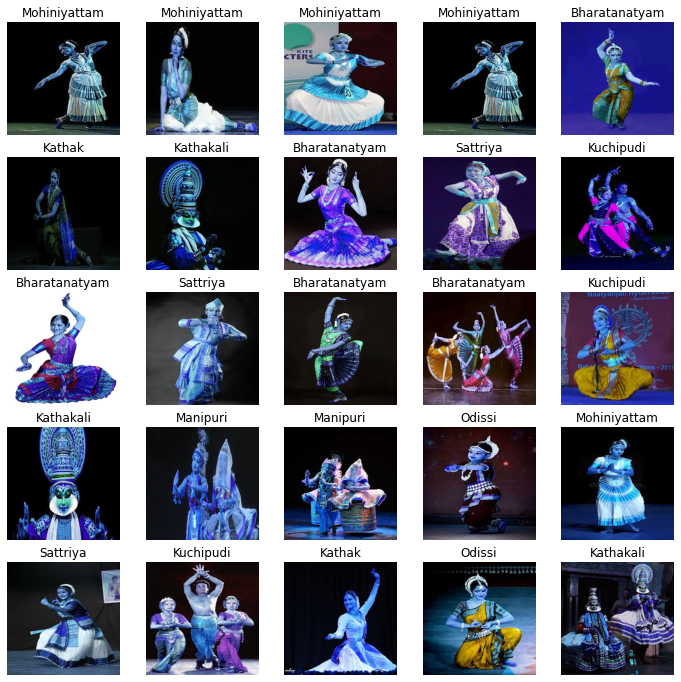

In [31]:
show_batch(training_data, training_labels)

In [32]:
testing_data = test_data_prepare(test_fnames, test_dir)

In [33]:
le = LabelEncoder()
training_labels = le.fit_transform(training_labels)

In [34]:
training_labels[:10]

array([5, 5, 5, 5, 0, 1, 2, 0, 7, 3])

In [37]:
X_train, X_val, y_train, y_val = train_test_split(training_data, training_labels, test_size=0.33, random_state=42)

In [38]:
# subsetting validation data
validation_data = training_data[300:]
validation_label =training_labels[300:]
training_data = training_data[:300]
training_labels = training_labels[:300]

In [39]:
train_datagenerator = ImageDataGenerator(
        rescale=1. / 255,
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        rotation_range=40,  
        zoom_range = 0.20,  
        width_shift_range=0.10,  
        height_shift_range=0.10,  
        horizontal_flip=True,  
        vertical_flip=False) 


test_datagenerator=ImageDataGenerator(
        rescale=1. / 255
)

train_datagenerator.fit(X_train)
test_datagenerator.fit(X_val)
test_datagenerator.fit(testing_data)
X_train=np.array(X_train)
testing_data=np.array(testing_data)
X_val=np.array(X_val)

In [42]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(243, 224, 224, 3)
(243,)
(121, 224, 224, 3)
(121,)


In [43]:
vggmodel =VGG16(weights='imagenet', include_top=False, input_shape = (224, 224, 3),pooling='max')

 # Print the model summary
vggmodel.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [60]:
vggmodel.trainable = False
model = Sequential([
  vggmodel, 
  Dense(1024, activation='relu'),
  Dropout(0.25),
  Dense(256, activation='relu'),
  Dropout(0.25),
  Dense(8, activation='softmax'),
])

In [61]:
import warnings
warnings.filterwarnings('ignore')
print('warnings ignored')

warnings ignored


In [62]:
reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                        factor=0.1,
                                        patience=2,
                                        cooldown=2,
                                        min_lr=0.00001,
                                        verbose=1)

callbacks = [reduce_learning_rate]

In [64]:
model.compile( optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history =model.fit_generator(
    train_datagenerator.flow(X_train, to_categorical(y_train,8), batch_size=16),
    validation_data=test_datagenerator.flow(X_val, to_categorical(y_val,8), batch_size=16),
    verbose=2,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
16/16 - 3s - loss: 2.6344 - accuracy: 0.1811 - val_loss: 1.8543 - val_accuracy: 0.3471
Epoch 2/30
16/16 - 3s - loss: 2.0760 - accuracy: 0.2551 - val_loss: 1.8086 - val_accuracy: 0.2810
Epoch 3/30
16/16 - 3s - loss: 1.8455 - accuracy: 0.3086 - val_loss: 1.6357 - val_accuracy: 0.4215
Epoch 4/30
16/16 - 3s - loss: 1.6896 - accuracy: 0.3663 - val_loss: 1.7047 - val_accuracy: 0.3388
Epoch 5/30
16/16 - 3s - loss: 1.6444 - accuracy: 0.4033 - val_loss: 1.4600 - val_accuracy: 0.5372
Epoch 6/30
16/16 - 3s - loss: 1.3494 - accuracy: 0.4897 - val_loss: 1.4219 - val_accuracy: 0.4793
Epoch 7/30
16/16 - 3s - loss: 1.2931 - accuracy: 0.5062 - val_loss: 1.4187 - val_accuracy: 0.4132
Epoch 8/30
16/16 - 3s - loss: 1.2446 - accuracy: 0.5267 - val_loss: 1.2774 - val_accuracy: 0.5868
Epoch 9/30
16/16 - 3s - loss: 1.1864 - accuracy: 0.6008 - val_loss: 1.1958 - val_accuracy: 0.5950
Epoch 10/30
16/16 - 3s - loss: 1.1899 - accuracy: 0.5514 - val_loss: 1.1741 - val_accuracy: 0.5868
Epoch 11/30
16/16 -

Text(0.5, 1.0, 'Training and validation loss')

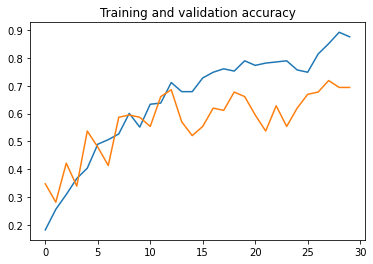

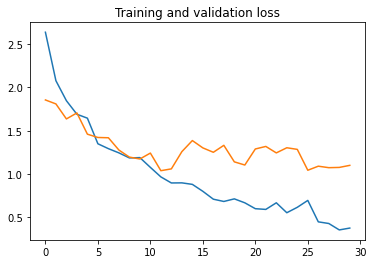

In [65]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc      = history.history[ 'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot( epochs, acc )
plt.plot( epochs, val_acc )
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [66]:
labels = model.predict(testing_data)
label = [np.argmax(i) for i in labels]

In [67]:
target=le.inverse_transform(label)

In [68]:
target[:25]

array(['kathakali', 'bharatanatyam', 'bharatanatyam', 'kathakali',
       'kathakali', 'kathakali', 'odissi', 'bharatanatyam',
       'bharatanatyam', 'bharatanatyam', 'kathak', 'kuchipudi',
       'kathakali', 'kathakali', 'kathakali', 'kathakali', 'kuchipudi',
       'mohiniyattam', 'mohiniyattam', 'bharatanatyam', 'kathakali',
       'bharatanatyam', 'kathakali', 'kathakali', 'bharatanatyam'],
      dtype='<U13')

In [71]:
submission = pd.DataFrame({'Image': test_df.Image, 'target': target })
submission.to_csv('submission1.csv', index=False)